In [2]:
pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/d9/28/3be76b591a2e14a031b681b8283acf1dec2ad521f6f1701b7957df68c466/lightgbm-4.5.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 660.6 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.4 MB 2.0 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.4 MB 2.6 MB/s eta 0:00:01
   ------------------------ --------------- 0.9/1.4 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency

import sys
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (D:\App\anaconda\Lib\site-packages\sklearn\utils\_param_validation.py)

In [5]:
df = pd.read_csv('feature_extraction.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35849 entries, 0 to 35848
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gioitinh              35849 non-null  int64  
 1   xeploai_tt            35849 non-null  int64  
 2   hocky                 35849 non-null  int64  
 3   namhoc                35849 non-null  int64  
 4   drltl                 35849 non-null  int64  
 5   sotchk                35849 non-null  int64  
 6   dtbhk_truoc           35849 non-null  float64
 7   xeploai               35849 non-null  int64  
 8   khuvuc_encoded        35849 non-null  int64  
 9   namnhaphoc            35849 non-null  int64  
 10  chuyennganh2_encoded  35849 non-null  float64
 11  hedt_encoded          35849 non-null  int64  
 12  khoa_encoded          35849 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 3.6 MB


#Feature Selection

## Filter method (Mutual Information)

In [7]:
features = df.drop(columns=['xeploai'])
target = df['xeploai']

In [8]:
mi_target = mutual_info_classif(features, target)

In [9]:
mi_target_df = pd.DataFrame({
    'Feature': features.columns,
    'Mutual Information': mi_target
})
mi_target_df = mi_target_df.sort_values(by='Mutual Information', ascending=False)
mi_target_df

,Feature,Mutual Information
6,dtbhk_truoc,0.366920
4,drltl,0.224603
5,sotchk,0.032722
10,hedt_encoded,0.030593
3,namhoc,0.029995
9,chuyennganh2_encoded,0.019795
8,namnhaphoc,0.018848
11,khoa_encoded,0.016086
0,gioitinh,0.010615
1,xeploai_tt,0.007581


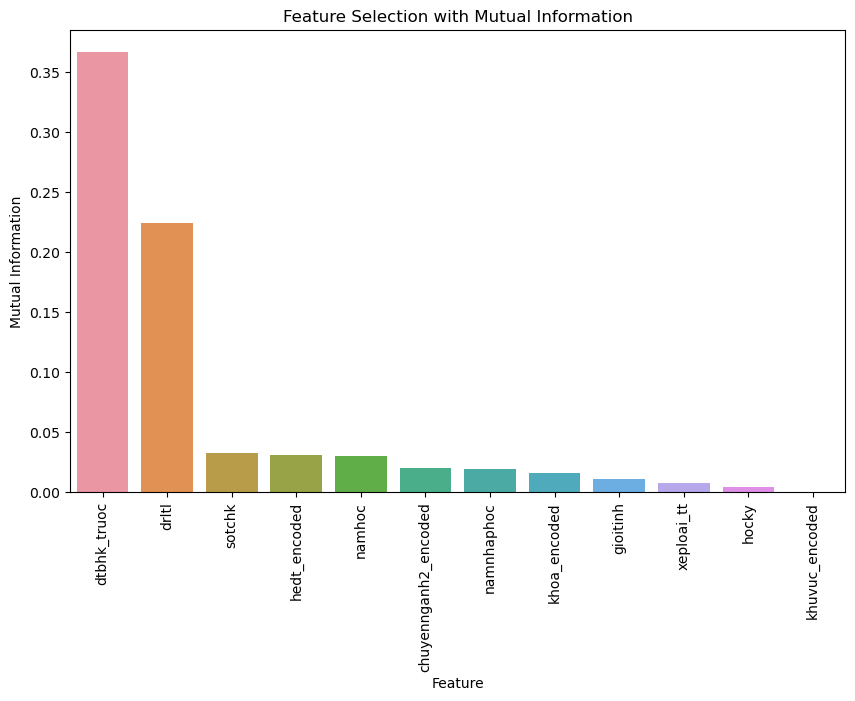

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Mutual Information', data=mi_target_df)
plt.xticks(rotation=90)
plt.title('Feature Selection with Mutual Information')
plt.show()

Có thể thấy dtbhk_truoc là thuộc tính quyết định đến xeploai, các thuộc tính tiếp theo như drltl, sotchk, hedt, namhoc (MI > 0.02). Ta tiếp tục thực hiện phân tích sâu hơn các biến này:

In [11]:
features = df[['dtbhk_truoc', 'drltl', 'sotchk', 'hedt_encoded', 'namhoc']]

## SelectKBest với SVM

In [12]:
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [13]:
features = df.drop(columns=['xeploai'])
target = df['xeploai']

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

# Chia dữ liệu thành train/test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Khởi tạo mô hình SVM
svm = SVC(kernel='linear')

# Áp dụng SelectKBest với f_classif (hàm phân tích phương sai F)
select_k_best = SelectKBest(score_func=f_classif, k=5)
X_train_k_best = select_k_best.fit_transform(X_train, y_train)

# In ra tên các đặc trưng đã chọn
selected_features_kbest = features.columns[select_k_best.get_support()]
print("Selected Features with SelectKBest: ", selected_features_kbest)


Selected Features with SelectKBest:  Index(['namhoc', 'drltl', 'sotchk', 'dtbhk_truoc', 'namnhaphoc'], dtype='object')


In [15]:
f_scores = select_k_best.scores_

In [16]:
f_scores_df = pd.DataFrame({
    'Feature': features.columns,
    'F-Statistic': f_scores
})

In [17]:
f_scores_df = f_scores_df.sort_values(by='F-Statistic', ascending=False)

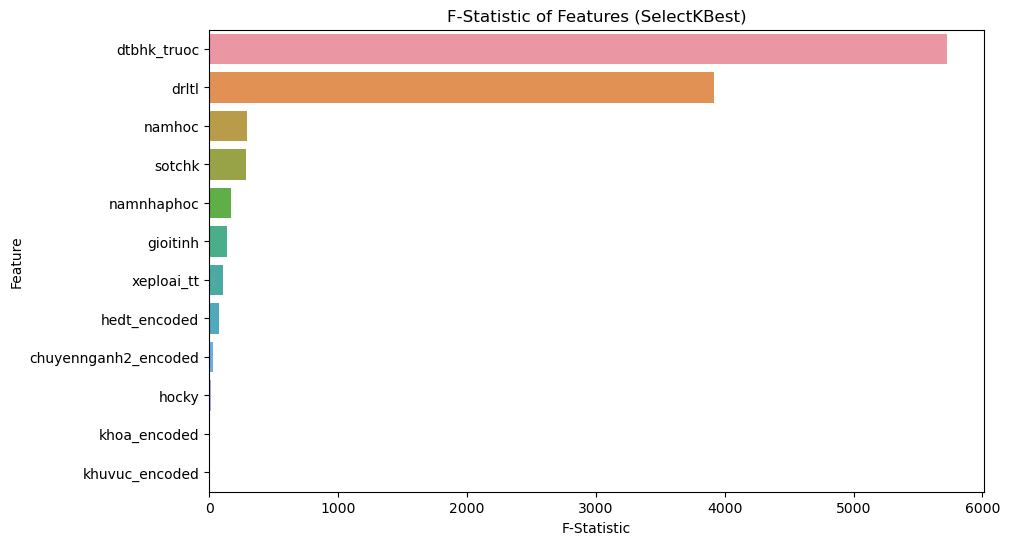

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='F-Statistic', y='Feature', data=f_scores_df)
plt.title('F-Statistic of Features (SelectKBest)')
plt.xlabel('F-Statistic')
plt.ylabel('Feature')
plt.show()

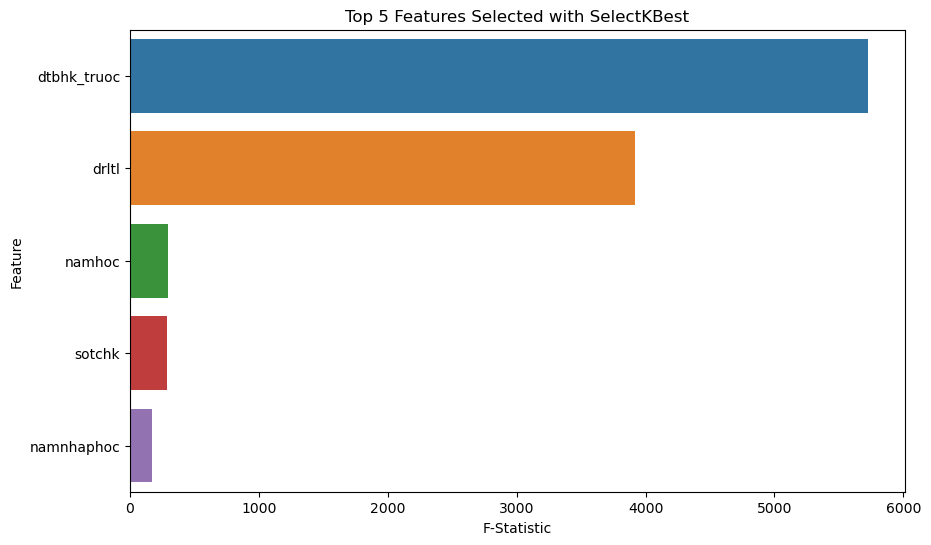

In [20]:
# Trực quan hóa các đặc trưng đã chọn
plt.figure(figsize=(10, 6))
sns.barplot(x='F-Statistic', y='Feature', data=f_scores_df.head(5))  # Top 5 features
plt.title('Top 5 Features Selected with SelectKBest')
plt.xlabel('F-Statistic')
plt.ylabel('Feature')
plt.show()

In [19]:
#Tính mối quan hệ MI giữa các cặp với nhau
mi_feature_pairs = pd.DataFrame(columns=features.columns, index=features.columns)
for feature1 in features.columns:
    for feature2 in features.columns:
        if feature1 != feature2:
            mi_value = mutual_info_classif(features[[feature1, feature2]], target)
            mi_feature_pairs.loc[feature1, feature2] = mi_value[0]
mi_feature_pairs

,gioitinh,xeploai_tt,hocky,namhoc,drltl,sotchk,dtbhk_truoc,khuvuc_encoded,namnhaphoc,chuyennganh2_encoded,hedt_encoded,khoa_encoded
gioitinh,NaN,0.019132,0.014027,0.013303,0.015182,0.00989,0.008738,0.007761,0.011475,0.011289,0.010801,0.010748
xeploai_tt,0.003475,NaN,0.008943,0.007063,0.009886,0.000606,0.007174,0.014361,0.003333,0.007568,0.006779,0.005575
hocky,0.001788,0.001001,NaN,0.00232,0.000521,0.001911,0.00264,0.004999,0.000527,0.002726,0.003929,0.001569
namhoc,0.029051,0.027871,0.027343,NaN,0.031228,0.024638,0.031639,0.025136,0.019154,0.031964,0.024314,0.028123
drltl,0.225816,0.228093,0.228942,0.221938,NaN,0.228033,0.2289,0.222752,0.227845,0.227458,0.233112,0.229522
sotchk,0.01695,0.02292,0.021877,0.021649,0.021711,NaN,0.033979,0.02123,0.019712,0.03458,0.025704,0.026927
dtbhk_truoc,0.363464,0.363275,0.364738,0.361854,0.364892,0.364039,NaN,0.359777,0.36472,0.365964,0.362583,0.36019
khuvuc_encoded,0.003197,0.008443,0.003878,0.005838,0.001212,0.001353,0.003584,NaN,0.004935,0.001635,0.005143,0.00222
namnhaphoc,0.015805,0.015411,0.017619,0.020946,0.013028,0.020943,0.022782,0.017711,NaN,0.026316,0.020889,0.017161
chuyennganh2_encoded,0.02145,0.01525,0.021083,0.018207,0.016934,0.013705,0.01817,0.018493,0.017892,NaN,0.022304,0.019989


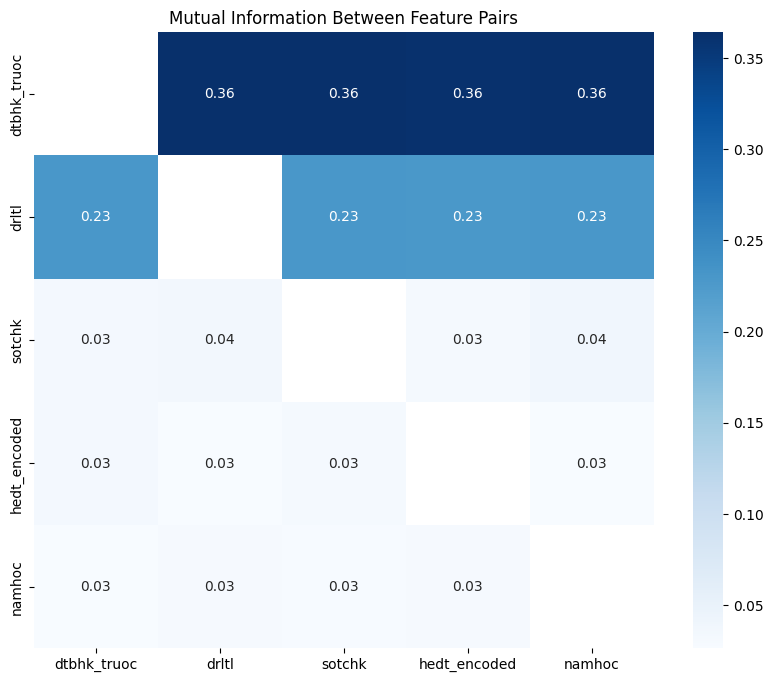

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(mi_feature_pairs.astype(float), annot=True, cmap='Blues', fmt='.2f', cbar=True)
plt.title('Mutual Information Between Feature Pairs')
plt.show()

Do dtbhk_truoc và namhoc có MI cao (0.37), chứng tỏ đây là một cặp có quan hệ chặt chẽ. Bên cạnh đó sotchk và drltl cũng có MI cao hơn so với các cặp quan hệ khác (0.04)

## Phân tích mối liên hệ giữa dtbhk_truoc và namhoc

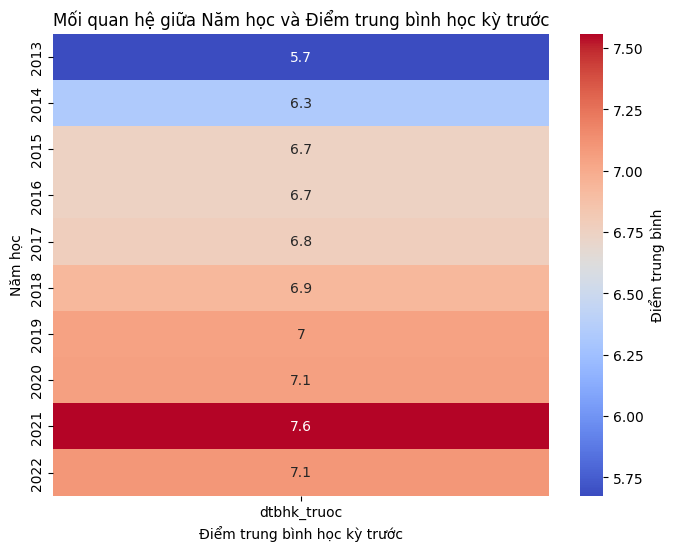

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo Pivot Table
pivot = df.pivot_table(index='namhoc', values='dtbhk_truoc', aggfunc='mean')

# Vẽ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Điểm trung bình'})
plt.title('Mối quan hệ giữa Năm học và Điểm trung bình học kỳ trước')
plt.xlabel('Điểm trung bình học kỳ trước')
plt.ylabel('Năm học')
plt.show()


Dựa vào hình trên, có thể thấy rõ xu hướng quan hệ tuyến tính giữa 2 biến này theo từng năm. Cụ thể, trong những năm gần đây, dtbhktruoc có xu hướng tăng dần, với các giá trị cao hơn so với các năm trước đó. Đây có thể phản ánh sự cải thiện trong chất lượng học tập của sinh viên qua các năm. Có thể chứng minh rõ ràng hơn qua việc phân khoảng các năm và thể hiện ở biểu đồ phân tán dưới đây

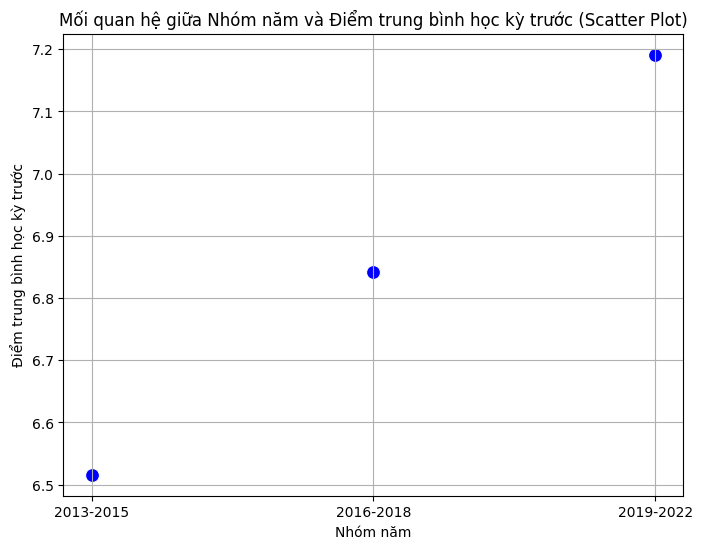

In [ ]:
df1 = df.copy()

# Thêm cột "Nhóm năm" để phân nhóm các năm
bins = [2013, 2015, 2018, 2022]
labels = ['2013-2015', '2016-2018', '2019-2022']
df1['nhom_nam'] = pd.cut(df['namhoc'], bins=bins, labels=labels, right=True)

# Tạo Pivot Table để tính điểm trung bình theo nhóm năm
pivot = df1.pivot_table(index='nhom_nam', values='dtbhk_truoc', aggfunc='mean')

pivot_reset = pivot.reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pivot_reset, x='nhom_nam', y='dtbhk_truoc', s=100, color='blue', marker='o')

plt.title('Mối quan hệ giữa Nhóm năm và Điểm trung bình học kỳ trước (Scatter Plot)')
plt.xlabel('Nhóm năm')
plt.ylabel('Điểm trung bình học kỳ trước')
plt.grid(True)
plt.show()

Ngoài ra, nhóm cũng thực hiện kiểm định Chisquare để chứng minh liên hệ giữa 2 biến

In [ ]:
dtb_contingency = pd.crosstab(df['dtbhk_truoc'], df['namhoc'])

dtb_chi2, dtb_p, _, _ = chi2_contingency(dtb_contingency)

{
    "chi2_statistic": dtb_chi2,
    "p_value": dtb_p
}


{'chi2_statistic': 14129.254850515426, 'p_value': 3.6682185101371154e-267}

In [ ]:
def cramers_v(chi2, n, dof):
    return np.sqrt(chi2 / (n * dof))

n = df.shape[0]
dtb_dof = dtb_contingency.shape[0] - 1

dtb_cramers_v = cramers_v(dtb_chi2, n, dtb_dof)

{
    "Hedt và xeploai": dtb_cramers_v
}


{'Hedt và xeploai': 0.020209587529910384}

Nhận xét: p_value < 0.5 (mức ý nghĩa) cho thấy namhoc ảnh hưởng đến dtbhktruoc, bên cạnh đó chỉ số cramer v nhằm đo mức độ mạnh yếu của các liên kết với chỉ số 0.02 cho thấy mối liên hệ khá mạnh ở 2 biến này

## Phân tích mối liên hệ giữa sotchk và drltl

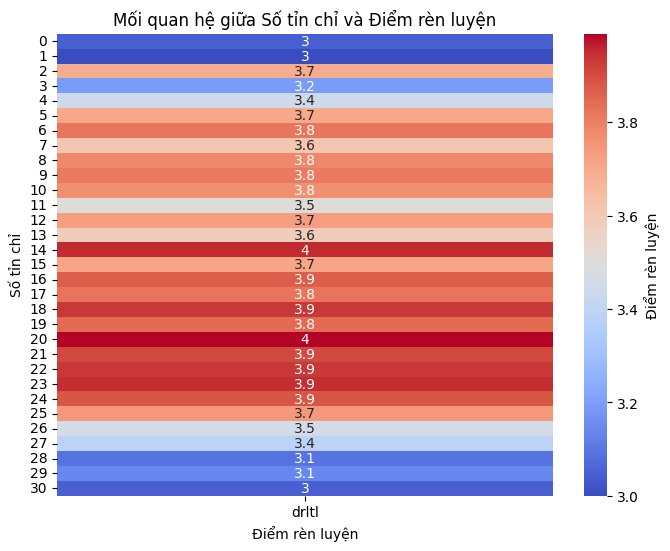

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo Pivot Table
pivot = df.pivot_table(index='sotchk', values='drltl', aggfunc='mean')

# Vẽ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Điểm rèn luyện'})
plt.title('Mối quan hệ giữa Số tỉn chỉ và Điểm rèn luyện')
plt.xlabel('Điểm rèn luyện')
plt.ylabel('Số tỉn chỉ')
plt.show()


Dựa vào hình trên, có thể thấy rõ xu hướng quan hệ giữa 2 biến này. Cụ thể:
- Ở mức độ tín chỉ đạt ngưỡng quy định thông thường của chương trình đào tạo (từ 14 đến 24), điểm rèn luyện thường ở mức cao nhất, đa phần nằm ở xếp loại tốt.
- Trong khi đó, các khoảng nằm ngoài (>24 và <14) lại có drltl thấp hơn, có thể là do sinh viên không tập trung học đủ số lượng môn hoặc quá tải dẫn kết quả học tập kỳ trước thước, ảnh hưởng đến điểm rèn luyện kỳ này.
- Có thể chứng minh rõ ràng hơn qua việc phân khoảng các năm và thể hiện ở biểu đồ phân tán dưới đây

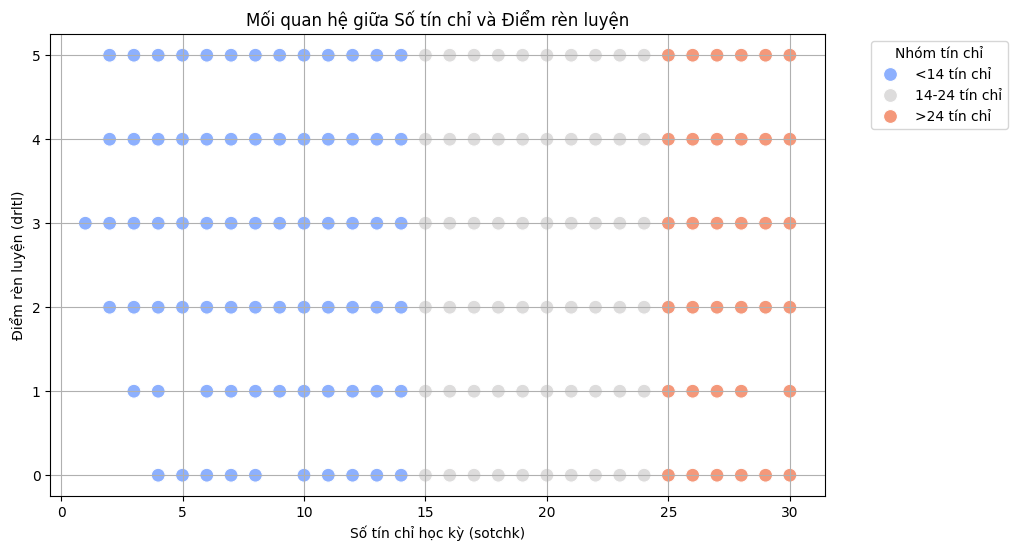

In [ ]:
df1 = df.copy()

bins = [0, 14, 24, float('inf')]  # Các nhóm tín chỉ
labels = ['<14 tín chỉ', '14-24 tín chỉ', '>24 tín chỉ']  # Nhãn nhóm tín chỉ
df1['nhom_tinchi'] = pd.cut(df1['sotchk'], bins=bins, labels=labels, right=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df1, x='sotchk', y='drltl', hue='nhom_tinchi', palette='coolwarm', s=100)

plt.title('Mối quan hệ giữa Số tín chỉ và Điểm rèn luyện')
plt.xlabel('Số tín chỉ học kỳ (sotchk)')
plt.ylabel('Điểm rèn luyện (drltl)')
plt.legend(title='Nhóm tín chỉ', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
dtb_contingency = pd.crosstab(df['drltl'], df['sotchk'])

dtb_chi2, dtb_p, _, _ = chi2_contingency(dtb_contingency)

{
    "chi2_statistic": dtb_chi2,
    "p_value": dtb_p
}


{'chi2_statistic': 1109.5411669457355, 'p_value': 4.7106086336993525e-146}

In [ ]:
def cramers_v(chi2, n, dof):
    return np.sqrt(chi2 / (n * dof))

n = df.shape[0]
dtb_dof = dtb_contingency.shape[0] - 1

dtb_cramers_v = cramers_v(dtb_chi2, n, dtb_dof)

{
    "Sotckhk và drltl": dtb_cramers_v
}


{'Sotckhk và drltl': 0.07867707129335524}

Nhận xét: p_value < 0.5 (mức ý nghĩa) cho thấy namhoc ảnh hưởng đến dtbhktruoc, bên cạnh đó chỉ số cramer v nhằm đo mức độ mạnh yếu của các liên kết với chỉ số 0.07 cho thấy mối liên hệ rất mạnh ở 2 biến này

# Xây dựng đồ thị mạng

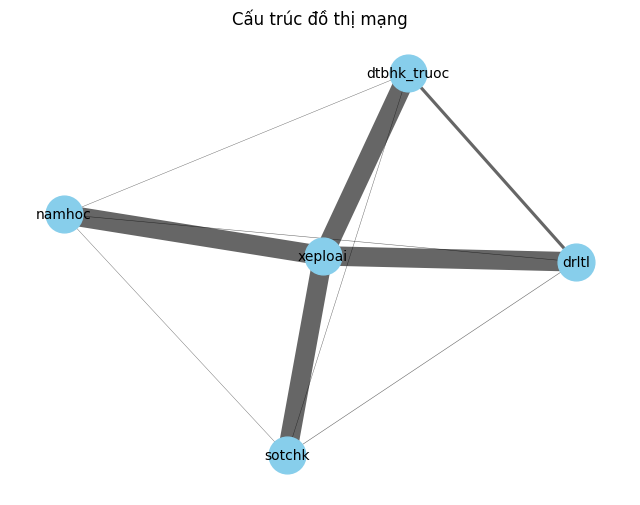

In [ ]:
import networkx as nx
top_features = ['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc']
top_features_with_label = top_features + ['xeploai']
df = df[top_features_with_label]

mi_matrix = pd.DataFrame(columns=df.columns, index=df.columns)

for feature1 in df.columns:
    for feature2 in df.columns:
        if feature1 != feature2:
            mi_value = mutual_info_classif(df[[feature1, feature2]], target)
            mi_matrix.loc[feature1, feature2] = mi_value[0]

G = nx.Graph()
G.add_nodes_from(top_features_with_label)

threshold = 0.03
for i in df:
    for j in df:
        if i != j and mi_matrix.loc[i, j] > threshold:
            G.add_edge(i, j, weight=mi_matrix.loc[i, j])

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))

edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[d['weight'] * 10 for (u, v, d) in edges],
    alpha=0.6
)

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

plt.title("Cấu trúc đồ thị mạng")
plt.axis('off')
plt.show()


# Các phương pháp xây dựng mạng

In [ ]:
df = pd.read_csv('feature_extraction.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35849 entries, 0 to 35848
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dtbhk_truoc   35849 non-null  float64
 1   drltl         35849 non-null  int64  
 2   sotchk        35849 non-null  int64  
 3   namhoc        35849 non-null  int64  
 4   xeploai       35849 non-null  int64  
 5   dtbhk_namhoc  35849 non-null  float64
 6   tl            35849 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.9 MB


## Sử dụng DictVectorizer

In [ ]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

df_dict = df.drop(['xeploai'], axis =1)

df_dict['dtbhk_namhoc'] = df_dict['dtbhk_truoc'] * df_dict['namhoc']
df_dict['tl'] = df_dict['sotchk'] * df_dict['drltl']

y = df['xeploai']

data_dict = df_dict.to_dict(orient='records')

vectorizer = DictVectorizer(sparse=True)
X = vectorizer.fit_transform(data_dict)

resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X, y)
xgb = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=1.0, subsample=0.9, random_state=42)

acc_xg = sum(cross_val_score(xgb, X, y, cv=10)) / 10

print(f"Accuracy: {acc_xg}")


Accuracy: 0.8869717001678262


In [ ]:
rf = RandomForestClassifier(n_estimators= 200, max_depth= 30, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', bootstrap=False)
acc_rf = sum(cross_val_score(rf, X, y, cv=10))/10
acc_rf

0.9241348383479135

In [ ]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

df_dict = df.drop(['xeploai'], axis =1)

df_dict['dtbhk_namhoc'] = df_dict['dtbhk_truoc'] * df_dict['namhoc']
df_dict['tl'] = df_dict['sotchk'] * df_dict['drltl']

y = df['xeploai']

data_dict = df_dict[['dtbhk_namhoc', 'tl']].to_dict(orient='records')

vectorizer = DictVectorizer(sparse=True)
X = vectorizer.fit_transform(data_dict)

resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X, y)
xgb = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=1.0, subsample=0.9, random_state=42)

acc_xg = sum(cross_val_score(xgb, X, y, cv=10)) / 10

print(f"Accuracy: {acc_xg}")


Accuracy: 0.8896694222756182


In [ ]:
rf = RandomForestClassifier(n_estimators= 200, max_depth= 30, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', bootstrap=False)
acc_rf = sum(cross_val_score(rf, X, y, cv=10))/10
acc_rf

0.9232974137050342

## Sử dụng ma trận kề

In [ ]:
import pandas as pd
import networkx as nx
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

adj_matrix = nx.adjacency_matrix(G).todense()
adj_df = pd.DataFrame(adj_matrix, columns=G.nodes, index=G.nodes)

adj_df['aggregated_connections'] = adj_df.sum(axis=1)

adj_df = adj_df.reindex(df.index, fill_value=0)

top_features = ['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc']  # Example features
df['aggregated_connections'] = adj_df['aggregated_connections']

X = df[top_features + ['aggregated_connections']]
y = df['xeploai']

X = X.dropna()
y = y.loc[X.index]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

xgb = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=1.0, subsample=0.9, random_state=42)
acc_xg = sum(cross_val_score(xgb, X, y, cv=10)) / 10

print(f"Accuracy: {acc_xg}")


Shape of X: (35849, 5)
Shape of y: (35849,)
Accuracy: 0.5809085086048017


## Sử dụng average pooling

In [ ]:
top_features = ['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc']
top_features_with_label = top_features + ['xeploai']
df = df[top_features_with_label]

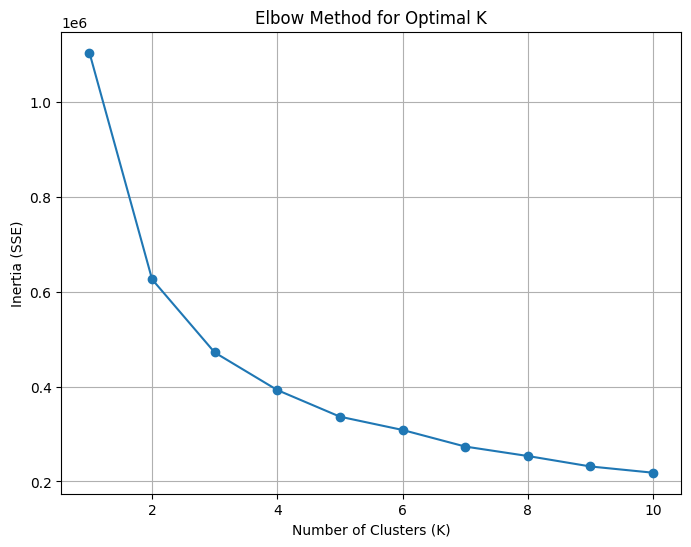

In [ ]:
data = df.copy()
k_values = range(1, 11)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data[top_features])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.grid(True)
plt.show()


=> k=3

Building Layer 1...
Building Layer 2...
Building Layer 3...


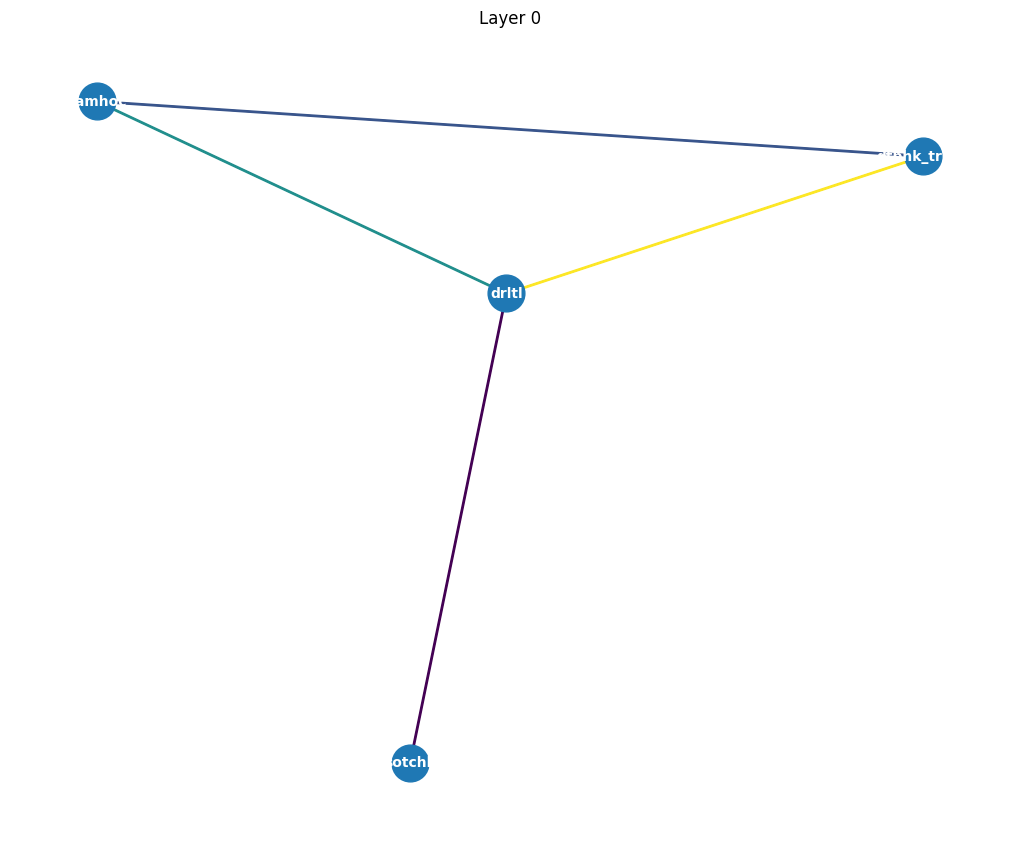

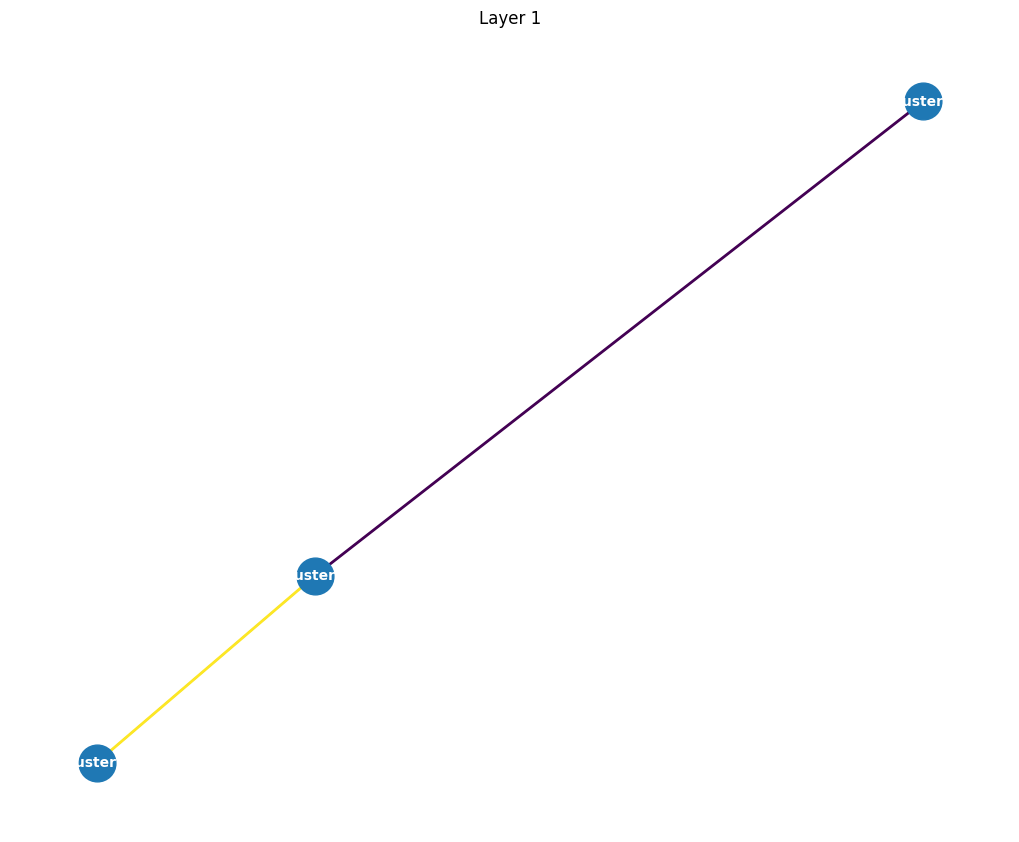

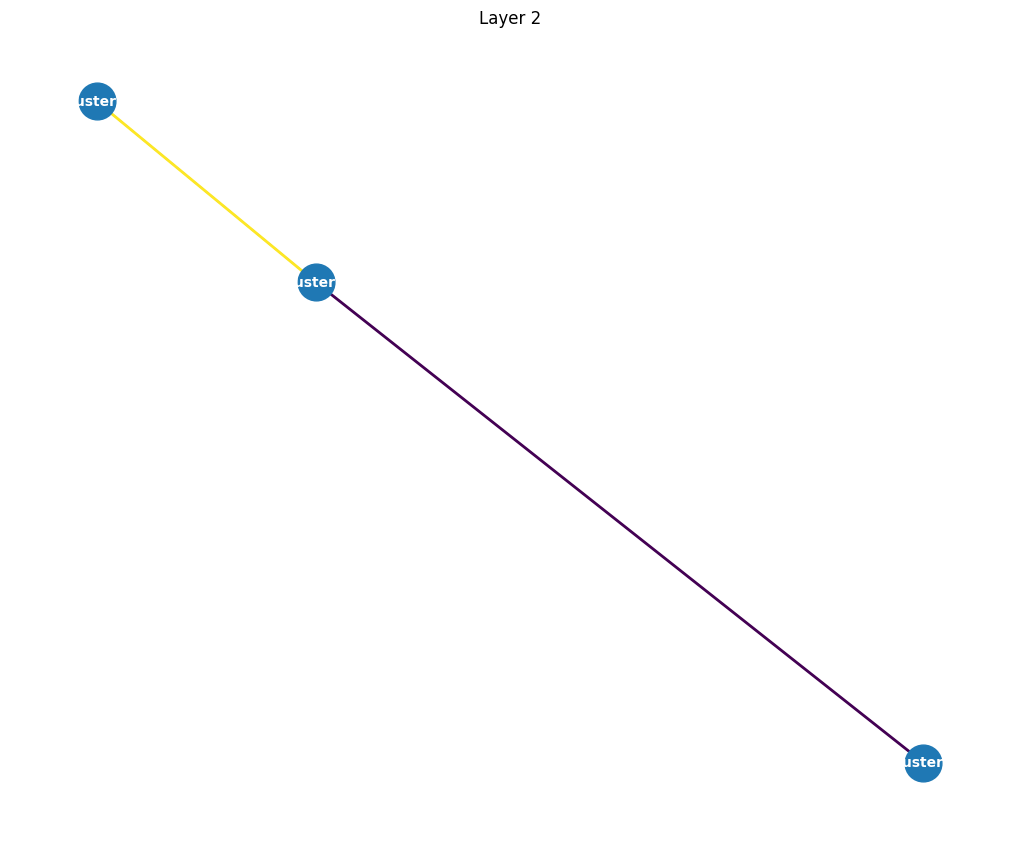

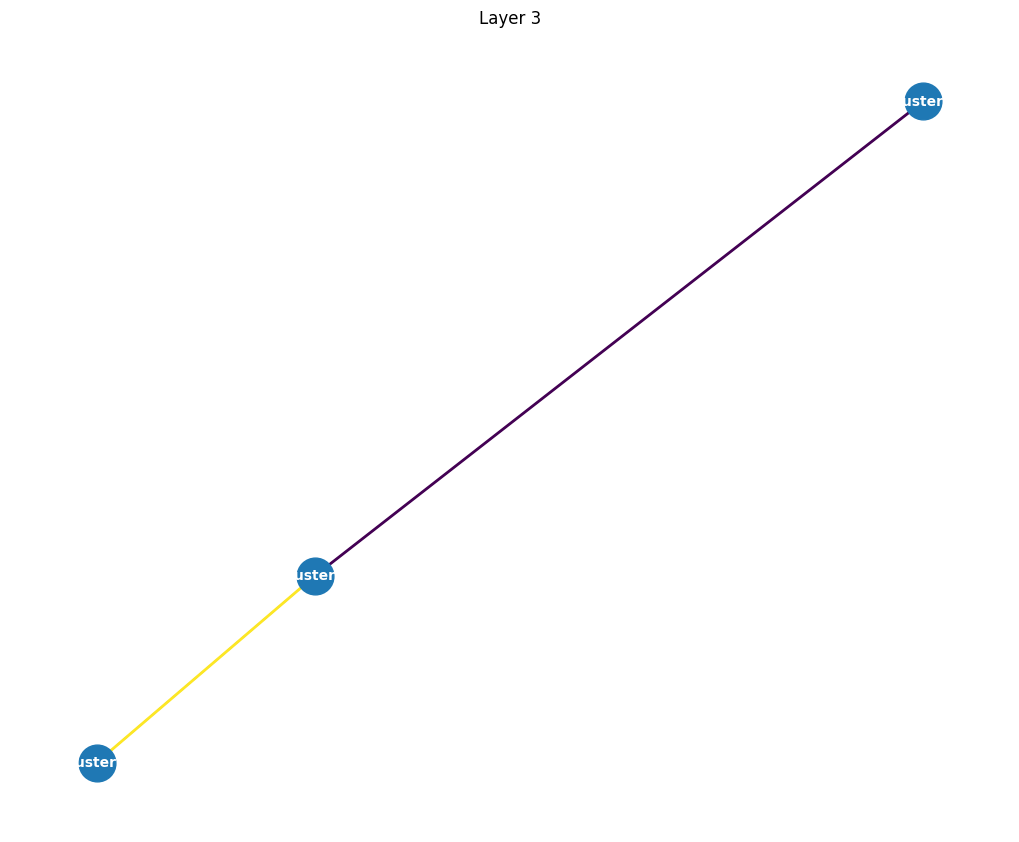

Pooled Data for Layer 0:
   dtbhk_truoc     drltl    sotchk    namhoc
0     1.065896  0.998521  0.747090  0.181935
1     1.157895  0.998521 -0.563109  0.609536
2     1.221144  0.998521  0.310357  0.609536
3     1.014147  0.998521  0.528724  1.037136
4     0.893398  0.998521  0.528724  1.037136
Pooled Data for Layer 1:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136
Pooled Data for Layer 2:
   Cluster_1  Cluster_2  Cluster_3
0   0.181935   0.747090   1.032209
1   0.609536  -0.563109   1.078208
2   0.609536   0.310357   1.109833
3   1.037136   0.528724   1.006334
4   1.037136   0.528724   0.945960
Pooled Data for Layer 3:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt


def build_initial_graph(W, feature_names):
    """
    Build the initial graph G₀ using a weight matrix.

    Args:
        W (np.ndarray): Weight matrix for features.
        feature_names (list): Names of the features (nodes).

    Returns:
        G (networkx.Graph): The initial feature graph.
    """
    G = nx.Graph()
    num_features = len(feature_names)
    for i, name in enumerate(feature_names):
        G.add_node(i, label=name)
    for i in range(num_features):
        for j in range(i + 1, num_features):
            if W[i, j] > 0:
                G.add_edge(i, j, weight=W[i, j])
    return G


def average_pooling_layer(data, clusters):
    """
    Perform average pooling for each cluster.

    Args:
        data (pd.DataFrame): Original feature data.
        clusters (list): List of clusters (each cluster is a list of feature indices).

    Returns:
        pd.DataFrame: Data with pooled (averaged) features for each cluster.
    """
    pooled_data = pd.DataFrame()
    for i, cluster in enumerate(clusters):
        cluster_data = data.iloc[:, cluster]  # Extract cluster columns
        pooled_data[f"Cluster_{i+1}"] = cluster_data.mean(axis=1)  # Average pooling
    return pooled_data


def cluster_graph(G, num_clusters):
    """
    Cluster nodes of the graph using hierarchical clustering.

    Args:
        G (networkx.Graph): Input graph.
        num_clusters (int): Number of clusters to create.

    Returns:
        clusters (list): List of clusters with node indices.
    """
    adj_matrix = nx.to_numpy_array(G)

    clustering = AgglomerativeClustering(
        n_clusters=num_clusters, metric='precomputed', linkage='average'
    )
    cluster_labels = clustering.fit_predict(1 - adj_matrix)  # Convert to similarity
    clusters = [[] for _ in range(num_clusters)]
    for node, label in enumerate(cluster_labels):
        clusters[label].append(node)
    return clusters


def hierarchical_clustering_with_pooling(data, W, feature_names, num_layers, num_clusters):
    """
    Perform hierarchical clustering and pooling to construct a deep feature network.

    Args:
        data (pd.DataFrame): Original feature data.
        W (np.ndarray): Initial weight matrix.
        feature_names (list): Names of features.
        num_layers (int): Number of layers in the hierarchy.
        num_clusters (int): Number of clusters per layer.

    Returns:
        pooled_layers (list): List of pooled data for each layer.
        graphs (list): List of graphs for each layer.
    """
    pooled_layers = [data]
    graphs = []

    G = build_initial_graph(W, feature_names)
    graphs.append(G)

    for layer in range(num_layers):
        print(f"Building Layer {layer + 1}...")
        clusters = cluster_graph(G, num_clusters)
        pooled_data = average_pooling_layer(pooled_layers[-1], clusters)  # Pool data
        pooled_layers.append(pooled_data)
        G = build_initial_graph(
            np.corrcoef(pooled_data.T, rowvar=True), pooled_data.columns
        )
        graphs.append(G)

    return pooled_layers, graphs


def visualize_graph(G, title="Feature Network"):
    """
    Visualize the graph.

    Args:
        G (networkx.Graph): Graph to visualize.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_size=700, font_size=10, font_color='white', font_weight='bold'
    )
    edge_colors = [d['weight'] for _, _, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.viridis, width=2)
    plt.title(title)
    plt.show()


# Example Usage with Your Dataset
if __name__ == "__main__":
    # Load your dataset
    df = df[['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc', 'xeploai']]  # Assuming df is your DataFrame
    feature_names = df.columns.drop('xeploai').tolist()  # Exclude label column

    # Standardize the features
    scaler = StandardScaler()
    standardized_features = pd.DataFrame(
        scaler.fit_transform(df[feature_names]), columns=feature_names
    )

    # Compute pairwise correlations as weights
    correlation_matrix = np.corrcoef(standardized_features.T)
    np.fill_diagonal(correlation_matrix, 0)  # Remove self-loops

    # Hierarchical clustering with average pooling
    num_layers = 3
    num_clusters = 3  # Adjust as needed
    pooled_layers, graphs = hierarchical_clustering_with_pooling(
        standardized_features, correlation_matrix, feature_names, num_layers, num_clusters
    )

    # Visualize each graph layer
    for i, G in enumerate(graphs):
        visualize_graph(G, title=f"Layer {i}")

    # Print pooled data for each layer
    for i, pooled_data in enumerate(pooled_layers):
        print(f"Pooled Data for Layer {i}:")
        print(pooled_data.head())


In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier

X_pooled = pooled_layers[-1]
y = df['xeploai']

resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = resampler.fit_resample(X_pooled, y)

xgb = XGBClassifier(
    max_depth=7,
    n_estimators=200,
    colsample_bytree=1.0,
    subsample=0.9,
    random_state=42
)

acc_xg = sum(cross_val_score(xgb, X_resampled, y_resampled, cv=10)) / 10

print(f"Accuracy: {acc_xg}")

Accuracy: 0.9619938500512497
